# Relax Data Science Challenge!

This notebook will be solving the problems featured in the Springboard Relax Data Science Challenge.

In [157]:
# Import libraries and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [2]:
# Import the data files
df = pd.read_csv(r'C:\Users\joshu\Downloads\1481069814_relax_challenge\relax_challenge\takehome_users.csv', engine = 'python')
df1 = pd.read_csv(r'C:\Users\joshu\Downloads\1481069814_relax_challenge\relax_challenge\takehome_user_engagement.csv', 
                  engine = 'python')

In [3]:
# Take a look at the dataframes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
# Join tables on user_id
df2 = df1.merge(right=df, how='outer', left_on='user_id', right_on='object_id')
df2.drop(['user_id', 'last_session_creation_time'], axis=1, inplace=True)

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 11 columns):
time_stamp                    207917 non-null object
visited                       207917 non-null float64
object_id                     211094 non-null int64
creation_time                 211094 non-null object
name                          211094 non-null object
email                         211094 non-null object
creation_source               211094 non-null object
opted_in_to_mailing_list      211094 non-null int64
enabled_for_marketing_drip    211094 non-null int64
org_id                        211094 non-null int64
invited_by_user_id            118528 non-null float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.3+ MB


## Data Wrangling

Before we start exploring the data, we will first need to inspect any outstanding issues within the datasets. 

Let's begin with the first dataframe containing information about the takehome users.

In [9]:
# Convert the date columns into datetime format
df2['creation_time'] = pd.to_datetime(df2['creation_time'])
df2['time_stamp'] = pd.to_datetime(df2['time_stamp'])

Next, there are many missing entries in the invited_by_user_id column. Since not everyone was invited by a user, we can simply fill in the missing cells with 'uninvited'.

In [10]:
# Fill in the missing values with 'Uninvited'
df2['invited_by_user_id'].fillna('Uninvited', inplace = True)

# Fill in missing time_stamp and visited values with 0
df2['time_stamp'].fillna(0, inplace=True)
df2['visited'].fillna(0,inplace=True)

In [11]:
# Rename the column 'object_id' to 'user_id'
df2.rename(index = str, columns = {'object_id':'user_id'}, inplace = True)

Finally, let's create another column that identifies whether or not the user is an "adopted user". An adopted user is defined as someone who has logged into the product on 3 separate days in at least one 7-day period.

In [24]:
# Initialize adopted feature
df2['adopted'] = np.zeros(df2.shape[0])

# Create a for-loop that checks every 3 consecutive time stamps
for t in range(2, df2.shape[0]):
    if df2['user_id'][t] == df2['user_id'][t-2]:   # Check if the 3 consecutive time stamps have the same user
        if (df2['time_stamp'][t] - df2['time_stamp'][t-2]) < pd.Timedelta('7 days'): # Check if they are all within a week
            df2['adopted'][t] = 1

C:\Users\joshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


4677.005528450012


In [27]:
# Create an empty array to store the information
adopted = np.zeros(df.shape[0])

# Create array adopted that indicates whether a user adopted
for t in range(2, df.shape[0]):
    if (df2['adopted'].iloc[t] > 0):
        user = df2['user_id'].iloc[t]
        adopted[user] = 1

In [28]:
# Set index of df to object_id
df.set_index('object_id', inplace=True)

# Add the adopted column to df
df['adopted'] = pd.Series(adopted, index=(df.index-1))

Let's create a new column called 'email_domain' whose entries are the email domains shown on their emails.

In [118]:
email_domain = []
for x in df['email']:
    domain = x.split('@')[1]
    email_domain.append(domain)
df['email_domain'] = email_domain

In [151]:
df['invited_by_user_id'].fillna('Uninvited', inplace = True)

In [48]:
# Save the .csv file for later use
df.to_csv(r'C:\Users\joshu\Downloads\1481069814_relax_challenge\relax_challenge\takehome_users1.csv')

## Data Exploration

Let's begin by exploring the number of adopted users vs unadopted users.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       11999 non-null float64
creation_dow                  12000 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [117]:
round(df['adopted'].sum()/df['adopted'].count(), 4)

0.0084

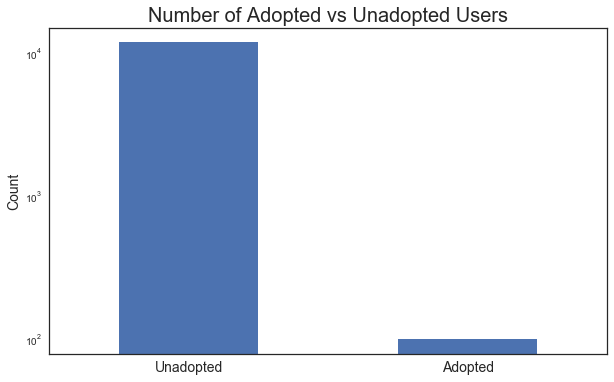

In [94]:
sns.set(style = 'white')
df.groupby('adopted')['adopted'].count().plot(kind='bar', figsize = (10,6))
plt.title('Number of Adopted vs Unadopted Users', fontsize = 20)
plt.xlabel('')
plt.xticks([0,1], ['Unadopted', 'Adopted'], rotation = 0, fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.yscale('log')
plt.show()

- Only 0.84% of all users are adopted.

- Out of the 12000 users in the platform, only 101 were adopted.

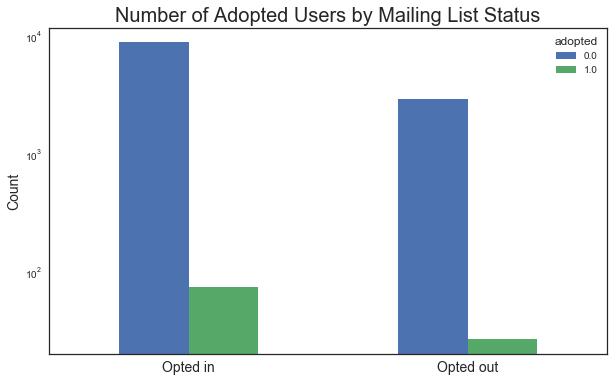

In [92]:
pd.crosstab(df['opted_in_to_mailing_list'], df['adopted']).plot(kind='bar', figsize=(10,6))
plt.title('Number of Adopted Users by Mailing List Status', fontsize = 20)
plt.xlabel('')
plt.xticks([0,1], ['Opted in', 'Opted out'], rotation = 0, fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.yscale('log')
plt.show()

- The number of adopted users doesn't seem to vary much when considering their mailing list status.

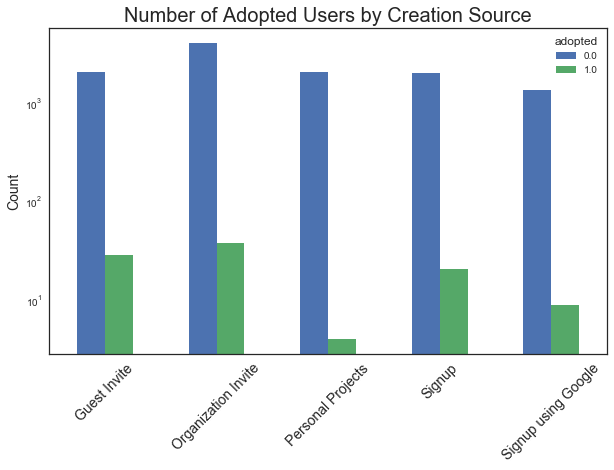

In [91]:
pd.crosstab(df['creation_source'], df['adopted']).plot(kind='bar', figsize=(10,6))
plt.title('Number of Adopted Users by Creation Source', fontsize = 20)
plt.xlabel('')
plt.xticks([0,1,2,3,4], ['Guest Invite', 'Organization Invite', 'Personal Projects', 'Signup', 'Signup using Google'], rotation = 45, fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.yscale('log')
plt.show()

- People who created their account via personal projects were much less likely to be adopted than other users.

- Organization invite and guest invite had the most adopted users, showing that the type of creation source seems to have an impact on whether or not users are adopted.

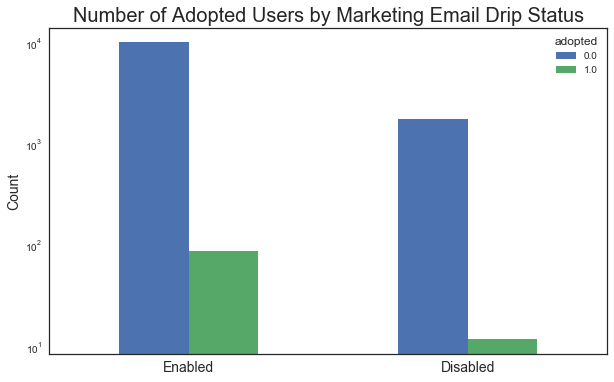

In [90]:
pd.crosstab(df['enabled_for_marketing_drip'], df['adopted']).plot(kind='bar', figsize=(10,6))
plt.title('Number of Adopted Users by Marketing Email Drip Status', fontsize = 20)
plt.xlabel('')
plt.xticks([0,1], ['Enabled', 'Disabled'], rotation = 0, fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.yscale('log')
plt.show()

- Users who disabled their marketing email drip were much less likely to be adopted compared to those who enabled it.

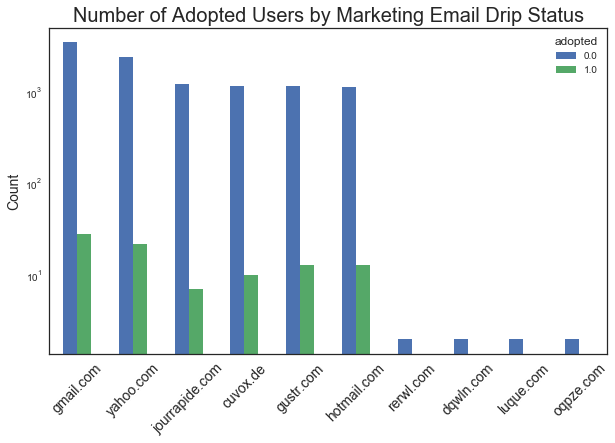

In [149]:
pd.crosstab(df['email_domain'], df['adopted']).sort_values(by = 0, ascending = False)[0:10].plot(kind='bar', figsize=(10,6))
plt.title('Number of Adopted Users by Marketing Email Drip Status', fontsize = 20)
plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.yscale('log')
plt.show()

- Users who used gmail, yahoo, gustr and hotmail were more likely to be adopted than other email domains.

## Machine Learning

- Problem: We want to predict the adoption status of a client (whether or not a client has logged into the product on 3 separate days in at least one 7-day period) and learn which features are the best predictors for it.


- Machine Learning algorithm: We will be using a Random Forest Classifier because some of the important features are categorical (opted_in_to_mailing_list, enabled_for_marketing_drip, creation_source).


- Evaluation Metrics: We will be focusing on accuracy (number of correct predictions/total number of predictions), precision (number of correct Adoption labels/total number of Adoption labels) and recall (number of correct Adoption labels/total number of actual Adoption users).

In [161]:
# Begin by creating dummy variables for the categorical features
dummy_df = pd.get_dummies(df, columns=['enabled_for_marketing_drip', 'creation_source', 'email_domain', 'org_id', 'invited_by_user_id'], drop_first=True)

In [162]:
# Create the feature and response variable sets
X = dummy_df.drop(['adopted', 'name', 'email', 'creation_time', 'last_session_creation_time'], axis = 1)
y = df['adopted']

In [163]:
# Begin by creating the pipeline steps. Start with scaling the data via StandardScaler and then the DummyRegressor estimator
steps = [('scaler', StandardScaler()), ('rf', RandomForestClassifier())]
pipeline = Pipeline(steps)
# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
# Fit the data into the pipeline
pipeline.fit(X_train,y_train)
# Predict the response variables using the test data
y_pred = pipeline.predict(X_test)

In [172]:
y_pred = (y_pred>0.5).astype(int)
y_test = (y_test>0.5).astype(int)

In [174]:
# Extract the Accuracy, Precision and Recall scores
print('Accuracy score of Random Forest classifier on test set: {:.4f}\n'.format(accuracy_score(y_test, y_pred)))
print('Precision score of Random Forest classifier on test set: {:.4f}\n'.format(precision_score(y_test, y_pred)))
print('Recall score of Random Forest classifier on test set: {:.4f}'.format(recall_score(y_test, y_pred)))

Accuracy score of Random Forest classifier on test set: 0.9892

Precision score of Random Forest classifier on test set: 0.0000

Recall score of Random Forest classifier on test set: 0.0000


In [176]:
# Organize the feature importances into a dataframe
rf_steps = pipeline.named_steps['rf'] # Use the .named_steps pipeline method to access random forest attributes
table_df = pd.DataFrame({'Features':np.array(X.columns), 'Importance':rf_steps.feature_importances_})
table_df.set_index('Features', inplace = True)
table_df.sort_values('Importance', ascending=False, inplace=True)
table_df.head(10)

,Importance
Features,
email_domain_gmail.com,0.046159
creation_source_ORG_INVITE,0.043626
opted_in_to_mailing_list,0.043595
email_domain_yahoo.com,0.042065
email_domain_jourrapide.com,0.025685
email_domain_gustr.com,0.020215
email_domain_cuvox.de,0.019348
email_domain_hotmail.com,0.019018
creation_source_SIGNUP,0.017677
